# We analyze the training dataset, extract correlations and build a supervised model to predict the wine score, and test the model on the test dataset. 

### Load all libraries and associated dependencies

In [6]:
# Basic Libraries for data processing
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
import nltk
from string import punctuation

In [20]:
# Feature Engineering in sklearn and nltk
from sklearn.preprocessing import LabelEncoder, Imputer
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [7]:
# sklearn dependencies for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

In [8]:
PATH = os.path.join(os.getcwd(), "ML_Case_Study")
os.chdir(PATH)

In [9]:
df_wine = pd.read_csv("wines.csv")

### Load our Test and Training Datasets. The datasets are small enough that we don't need to make SQL queries, in fact that might be slower, so we just work with Pandas in this case

In [7]:
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,Tastes just a little sweet in citrus and tropi...,NaN,86,16.0,California,Napa Valley,Napa,Sauvignon Blanc,Honig
1,Italy,"There's a meaty, ripe aspect to the aromas her...",NaN,87,NaN,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Canneta
2,Italy,Made from biodynamically farmed Bombino Bianco...,Lefkò,88,30.0,Southern Italy,Castel del Monte,NaN,Bombino Bianco,Cefalicchio
3,Spain,"Bramble, cherry cola and snappy red berry arom...",Cuvée Especial,91,24.0,Northern Spain,Rioja,NaN,Tempranillo,Sierra Cantabria
4,Italy,Cygnus is a very distinct blend of Nero d'Avol...,Cygnus,90,30.0,Sicily & Sardinia,Sicilia,NaN,Red Blend,Tasca d'Almerita


In [8]:
df_wine.info() # get the objects in the dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 10 columns):
country        120741 non-null object
description    120744 non-null object
designation    84110 non-null object
points         120744 non-null int64
price          109780 non-null float64
province       120741 non-null object
region_1       100682 non-null object
region_2       48603 non-null object
variety        120744 non-null object
winery         120744 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 9.2+ MB


#### As always we remove duplicates first based on the descriptions and drop rows with no price or points or country. Still a pretty large dataset so we're good.


In [10]:
df_duplicates_dropped = df_wine.drop_duplicates(subset = 'description')
df_cleaned = df_duplicates_dropped.dropna(subset=['price', 'points', 'country', 'variety'])
df_fully_cleaned = df_cleaned.drop(['region_2'], axis = 1)
df_fully_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77418 entries, 0 to 120743
Data columns (total 9 columns):
country        77418 non-null object
description    77418 non-null object
designation    53412 non-null object
points         77418 non-null int64
price          77418 non-null float64
province       77418 non-null object
region_1       64736 non-null object
variety        77418 non-null object
winery         77418 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 5.9+ MB


## Exploratory Data Analysis

### 1) First let's find out if this is a classification or regression problem by plotting the scores

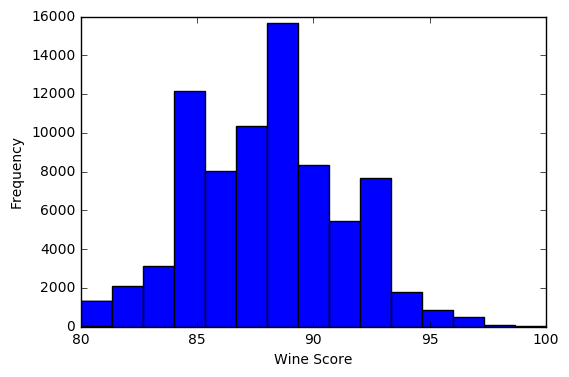

In [10]:
df_cleaned['points'].plot(kind = 'hist', bins = 15)
plt.xlabel('Wine Score')

In [119]:
print("Mean of Point Distribution =", df_cleaned.points.mean())
print("Std dev of Point Distribution =", df_cleaned.points.std())

Mean of Point Distribution = 87.8482006768
Std dev of Point Distribution = 3.21667200007


### 2) We expect Price to be correlated with the Score - so let's use pandas pair plots to visualize this

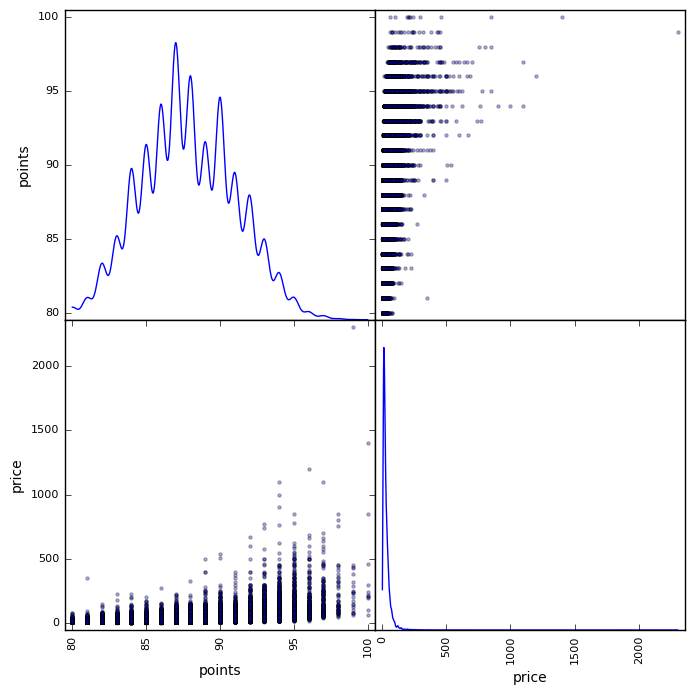

In [214]:
figure = os.path.join(PATH, 'points_price_corr.png')
pd.scatter_matrix(df_cleaned[['points', 'price']], alpha = 0.3, figsize = (8,8), diagonal = 'kde')
ax.set_xlabel(ax.get_xlabel(), fontsize =25) 
ax.set_ylabel(ax.get_ylabel(), fontsize =25) 
plt.savefig(figure)
plt.show()

# 3) Categorical variables: countries, regions, varieties and wineries. 
#### This is important because there are way too many categories for some variables -- 45 countries,  almost 600 wines -- we can't build a model which captures all of these as separate features, as such a model will not generalize well. Indeed some countries such as Albania only have one wine -- can't do much with that. So we group the data into bins based on the most frequent. The binning we use is as follows:

#### Countries: 8 bins -- US, France, Italy, Spain, Argentina, Chile, Australia and rest of the world.
#### Wine Varieties: binary -- the top 10 wines labeled 0 and remainder labeled 1. ( This ensures labeled data isn't imbalanced)
#### Provinces: Seems reasonable to divide the world into 30 provinces -- we can make this a hyperparameter to tune later, but I won't do this. 
#### Regions: Impute the data with corresponding provinces where applicable, divide into 30 regions. 

In [122]:
def label_encoder(df, column_name, labels, binarize = False):
    vals = df[column_name].value_counts()[:labels].index
    varieties = defaultdict(int)
    counter = 0
    for val in vals:
        varieties[val] = counter
        if binarize:
            counter = 0
        else:
            counter+=1
    return varieties, counter

def create_new_column(df, column_name, labels, binarize = False):
    res = label_encoder(df, column_name, labels, binarize)
    new_list = []
    for x in range(len(df[column_name])):
        if df[column_name].iloc[x] in res[0]:
            new_list.append(res[0][df[column_name].iloc[x]])
        else:
            new_list.append(res[1])
    df['{}_labels'.format(column_name)] = new_list

In [43]:
create_new_column(df_fully_cleaned, 'country', 8)

In [44]:
df_fully_cleaned['region_1']=df_fully_cleaned['region_1'].fillna(df_fully_cleaned['province'])

In [45]:
create_new_column(df_fully_cleaned, 'province', 30)
create_new_column(df_fully_cleaned, 'region_1', 30)
create_new_column(df_fully_cleaned, 'variety', 10, binarize = True)

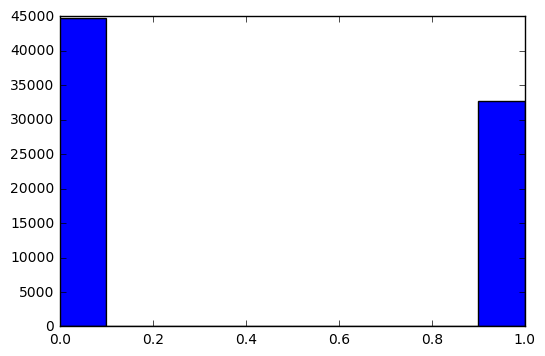

In [10]:
create_new_column(df_fully_cleaned, 'variety', 10, binarize = True)
plt.hist(df_fully_cleaned['variety_labels'], bins = 10) # Histogram of new labels. 
plt.show()

### Let's look at the dataframe now having converted categorial variables to features

In [38]:
df_fully_cleaned.head()

,country,description,designation,points,price,province,region_1,variety,winery,country_labels,variety_labels,province_labels,region_1_labels,descr_length
0,US,Tastes just a little sweet in citrus and tropi...,NaN,86,16.0,California,Napa Valley,Sauvignon Blanc,Honig,0,0,0,0,37
2,Italy,Made from biodynamically farmed Bombino Bianco...,Lefkò,88,30.0,Southern Italy,Castel del Monte,Bombino Bianco,Cefalicchio,1,1,17,31,33
3,Spain,"Bramble, cherry cola and snappy red berry arom...",Cuvée Especial,91,24.0,Northern Spain,Rioja,Tempranillo,Sierra Cantabria,3,1,3,7,48
4,Italy,Cygnus is a very distinct blend of Nero d'Avol...,Cygnus,90,30.0,Sicily & Sardinia,Sicilia,Red Blend,Tasca d'Almerita,1,0,12,12,51
5,US,"This has lots of ripe, jammy raspberry and che...",NaN,83,50.0,California,Sonoma County,Syrah,Super Sonoman,0,0,0,8,24


### Having dealt with the categorical variables, let's make a correlation plot with the score using seaborn's pair plot tools.

#### Specifically let's color the plots by the binary variety labels to see if the price or point distributions vary for the different varieties -- we find that they are nearly identical, which means good wine score wines are found from the top 10 and remainder. As a wine lover, that makes sense as I've had many good wines that are outside the top 10 category. Wines in the bottom 10 tend to be cheaper however. Also there is an interesting shoulder in the distribution of points, which for top 10 wines is skewed towards higher point scores. Interesting! 

/Users/stefan/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/stefan/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/stefan/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


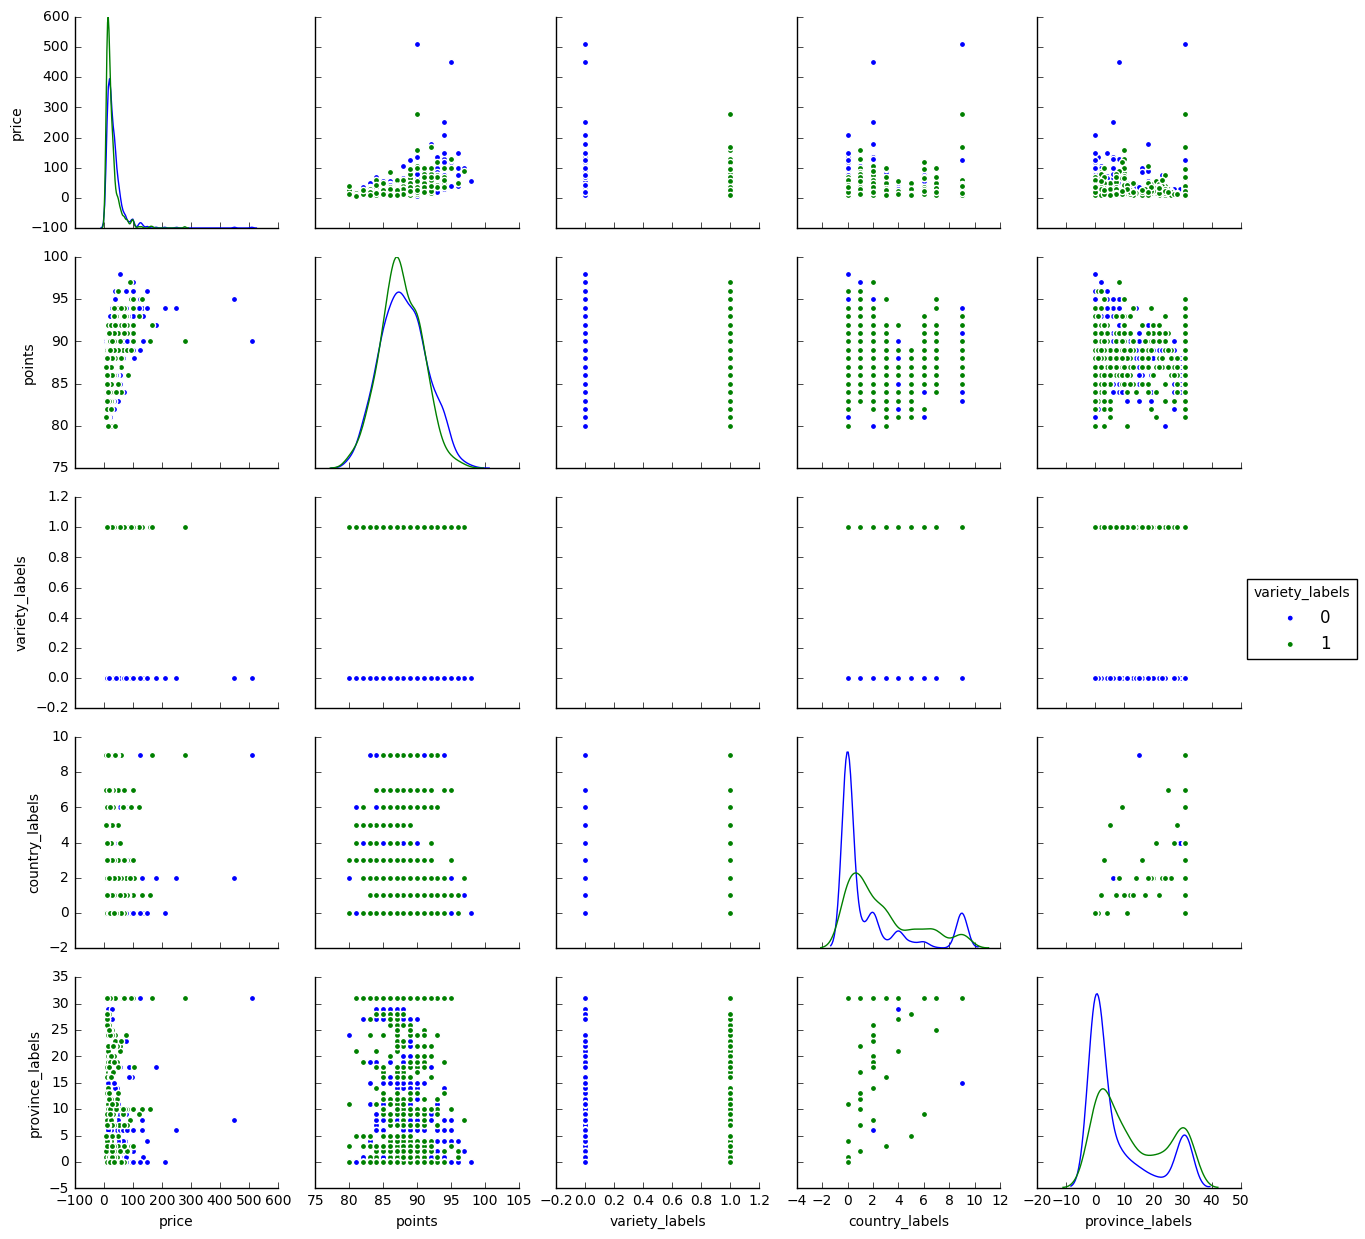

In [39]:
figure = os.path.join(PATH, 'categorical_correlations.png')
sns.pairplot(df_fully_cleaned[['price', 'points', 'variety_labels', 'country_labels', 
                               'province_labels']][:1000], kind = 'scatter', diag_kind = 'kde',
            hue = 'variety_labels')
plt.savefig(figure)
plt.show()

## Given the region_2 and designation categories have a lot of missing labels, we don't include these in our modeling. Instead we move on to the most fun category of all, the descriptions

### Do longer descriptions imply better wine scores?

In [47]:
text_length = []
for items in range(len(df_fully_cleaned['description'])):
    text_length.append(len(df_fully_cleaned['description'].iloc[items].split()))
df_fully_cleaned['descr_length'] = text_length

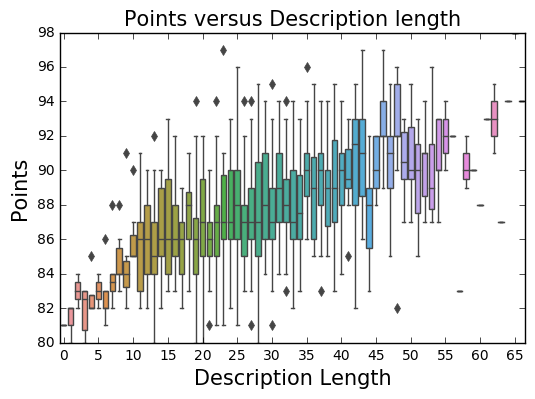

In [49]:
figure = os.path.join(PATH, 'points_descritopn_barplot.png')
h = sns.boxplot(x=df_fully_cleaned['descr_length'][:1000], y=df_fully_cleaned['points'][:1000])
h.xaxis.set_major_locator(ticker.MultipleLocator(5))
h.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlabel("Description Length", size = 15)
plt.title("Points versus Description length", size = 15)
plt.ylabel("Points", size = 15)
plt.savefig(figure)
plt.show()

### Description length is only one feature. Let's actually use the descriptions themselves by doing some NLP! 
### We tokenize all the description text and use a simple term-frequency-inverse-document-frequency model to find the most popular terms. This allows us to convert the description text into numerical feature vectors which we can additionally include in our model

In [17]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [word for word in simple_preprocess(doc) if word not in stop_words]

no_features = 100
tfidf = TfidfVectorizer(max_df=0.95, min_df=2
                          , max_features=no_features, stop_words='english')

In [18]:
#df_fully_cleaned['description'].iloc[1]
tokenized_text = [" ".join([word for word in simple_preprocess(df_fully_cleaned['description'].iloc[item]) if word not in stop_words])
                  for item in range(len(df_fully_cleaned['description']))]

In [19]:

text_vectors = tfidf.fit_transform(tokenized_text)

### We now have the feature vectors needed to build our regression model but just for fun ,lets ask what are the popular topics? To do this, we use a simple NMF model.

In [21]:
no_topics = 10
tfidf_feature_names = tfidf.get_feature_names()
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(text_vectors)

In [22]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
wine fruit spice character vineyard wood great mouth shows mineral
Topic 1:
apple citrus fresh white crisp green acidity peach lemon pear
Topic 2:
palate finish aromas nose notes fruit plum long herbal medium
Topic 3:
sweet oak vanilla flavors like chardonnay little toast smoky raspberry
Topic 4:
dry flavors pinot good cherries cola tannic shows little cherry
Topic 5:
black cherry tannins blackberry dark chocolate pepper plum currant licorice
Topic 6:
cabernet blend sauvignon merlot syrah cassis tobacco style blackberry oak
Topic 7:
soft drink easy fruity flavors chocolate texture light cherries blackberry
Topic 8:
ripe rich acidity fruits drink tannins years age texture wood
Topic 9:
red berry cherry bright raspberry spice light plum fresh flavors


In [23]:
clustering_model = KMeans(
    n_clusters=7,
    max_iter=100,
    precompute_distances="auto",
    n_jobs=-1)

labels = clustering_model.fit_predict(text_vectors)

In [35]:
reduced_data = PCA(n_components=2).fit_transform(text_vectors.todense()[:10000])

#### Topic 1 talks about spice and minerals, topic 2 and 7 are more citrus, easy drinking respectively, topic 3 is about medium body and 4 is about light pinots. This is interesting! Text is cool but pictures are cooler! Since our dataset is small, perhaps we can use T-SNE or PCA to visualize the word-topic embeddings.  

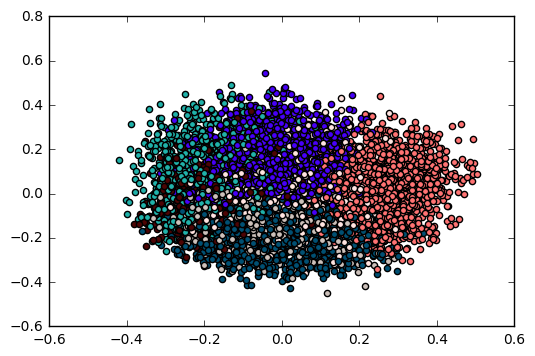

In [37]:
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
figure = "PCA_of_word_embeddings.jpeg"
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    plt.scatter(pca_comp_1, pca_comp_2, c=color)
plt.savefig(figure)
plt.show()

### Okay, let's build a model now. Combining the tfidf vectors with the categorical features, we create a Regression model, and try out both linear and random forest regression. 

### Let's randomly split the training data into train and validation and train a model on the dataset. We'll try two models -- Random forest and gradient boosted regression -- one with the tfidf embeddings as features and one without. 

### But as always, let's make a linear regression model to baseline all this. 

In [151]:
training_data_labels = ['price', 'country_labels','province_labels', 'region_1_labels'
                        , 'variety_labels', 'descr_length']
                        
X = pd.concat([df_fully_cleaned['{}'.format(x)] for x in training_data_labels], axis = 1)
y = df_fully_cleaned['points']

In [152]:
print(np.shape(y), np.shape(X))

(77418,) (77418, 6)


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
X_train = X_train.astype(np.float32) # reduce to 32 bit float

In [164]:
lin = LinearRegression()
reg = RandomForestRegressor(max_depth=4, random_state=0)
grd =GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
                                learning_rate = 0.01, loss = 'ls')

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train) 
scaled_X_test = scaler.fit_transform(X_test)

### Write function to execute models and compute feature importances

In [165]:
def run_model(model, train_data, train_labels, test_data, test_labels):
    my_model = model.fit(train_data, train_labels)
    model_mse = mean_squared_error(test_labels, my_model.predict(test_data))
    print("MSE: %.4f" % model_mse)
    try:
        return model.feature_importances_
    except AttributeError:
        return "Has no Feature Importances"

### Baseline Linear Regression Model

In [166]:
run_model(lin, scaled_X_train, y_train, scaled_X_test, y_test)

MSE: 6.2619


'Has no Feature Importances'

### Random Forest MSE and Feature Importances: 

In [158]:
reg_model = run_model(reg, scaled_X_train, y_train, scaled_X_test, y_test)
[print(training_data_labels[item],":",reg_model[item]) 
 for item in range(len(training_data_labels))]

MSE: 5.4106
price : 0.685393668556
country_labels : 0.0
province_labels : 0.0340210262729
region_1_labels : 0.0
variety_labels : 0.0
descr_length : 0.280585305171


[None, None, None, None, None, None]

### Gradient Boosting MSE

In [168]:
grd_model = run_model(grd, scaled_X_train, y_train, scaled_X_test, y_test)
[print(training_data_labels[item],":",grd_model[item]) 
 for item in range(len(training_data_labels))]

MSE: 4.6366
price : 0.348301006964
country_labels : 0.200297506572
province_labels : 0.112233650715
region_1_labels : 0.0848250502473
variety_labels : 0.00862361575683
descr_length : 0.245719169745


[None, None, None, None, None, None]

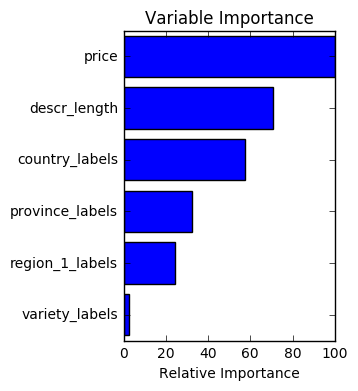

In [169]:
# Let's plot this in a nice way
figure = "Gradient_Boosting_without_NLP_features.png"
feature_importance = grd_model
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_labels = [training_data_labels[idx] for idx in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(figure)
plt.show()

### So the gradient boosting model has the lowest MSE of 4.6 out of the average of 87 . While the Random Forest regressor uses only price and description length info, gradient boosting uses country labels and province labels as well, achieving a lower MSE. 

#### Although we can hyperparameter tune ad infinitum, it's much more interesting to ask whether including the NLP features will have a big impact on the model accuracy. 

In [128]:
full_feature_names = training_data_labels +  tfidf_feature_names

In [129]:
full_X = np.concatenate((X, text_vectors.todense()), axis = 1).astype(np.float32)
y = df_fully_cleaned['points']

In [130]:
X_train_full_scaled, X_test_full_scaled, y_train, y_test = train_test_split(scaler.fit_transform(full_X), 
                                                            y, test_size=0.2, random_state=42)

In [132]:
full_reg_model = run_model(reg, X_train_full_scaled, y_train, X_test_full_scaled, y_test)
[print(training_data_labels[item],":",full_reg_model[item]) 
 for item in range(len(training_data_labels))]

MSE: 5.2656
price : 0.686104455754
country_labels : 0.0
province_labels : 0.0326668537236
region_1_labels : 0.0
variety_labels : 0.0
descr_length : 0.281228690522


[None, None, None, None, None, None]

In [171]:
full_grd_model = run_model(grd, X_train_full_scaled, y_train, X_test_full_scaled, y_test)
[print(training_data_labels[item],":",full_grd_model[item]) 
 for item in range(len(training_data_labels))]

MSE: 4.2332
price : 0.250103948647
country_labels : 0.0331418010989
province_labels : 0.0424269797292
region_1_labels : 0.00282009590395
variety_labels : 0.000516853466061
descr_length : 0.138689166306


[None, None, None, None, None, None]

In [ ]:
figure = "Gradient_Boosting_with_NLP_features.png"
feature_importance = full_grd_model[:20]
make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[:20]
sorted_labels = [full_feature_names[idx] for idx in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(figure)
plt.show()

#### A bit of hyperparameter tuning

In [134]:
lr = [0.001, 0.025, 0.05, 0.075, 0.1]
y_pred = [0]*len(X_test_full)
pred_vec = [0]*len(X_test_full)
mse_old = 1e10
mse = 0
for rate in lr:
    grd =GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
                                learning_rate = rate, loss = 'ls')
    grd.fit(X_train_full_scaled, y_train)
    pred_vec= grd.predict(X_test_full_scaled)
    mse = mean_squared_error(y_test, pred_vec)
    if mse < mse_old:
        mse_old = mse
        y_pred = pred_vec
        print("Lower MSE found at learning rate = {}".format(rate), mse_old)

Lower MSE found at learning rate = 0.001 7.24759206209
Lower MSE found at learning rate = 0.025 3.78986518887
Lower MSE found at learning rate = 0.05 3.59857016159
Lower MSE found at learning rate = 0.075 3.54062137512
Lower MSE found at learning rate = 0.1 3.52001670096


### The fact that the MSE flattens out tells us that to get more improvement, we need more training data or more feature engineering.

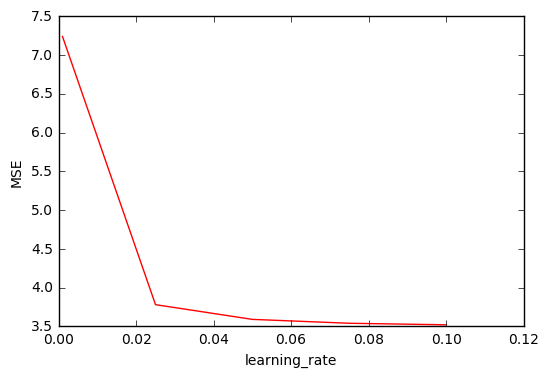

In [143]:
figure = "Gradient_Boosted_MSE.png"
x = lr
y = [7.24, 3.78, 3.59,3.54, 3.52]
plt.plot(x, y, 'r-')
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.savefig(figure)

#### This shows that more than region_1, balance, aroma, and acidity play an important role in determining the wine quality score! We learned something! Notice also that 100 features is quite redundant - balance and balanced are present as different features -- but one can easily preprocess the data better to ensure this doesn't happen using NLTK to only capture nouns. 

### Further Analysis of model - obviously this can be improved by hyperparameter tuning -- but our MSE is pretty good, this means an average error of +-2 (since MSE squares the error)
### Instead of further hyperparameter tuning, it's more useful to understand if there are any patterns in where our model is going wrong. We analyze that next, and then run the model on the test data. 

In [60]:
grd_model = grd.fit(X_train_full, y_train)
y_pred = grd.predict(X_test_full)

In [136]:
test_df = pd.DataFrame({"pred": y_pred, "test": y_test})

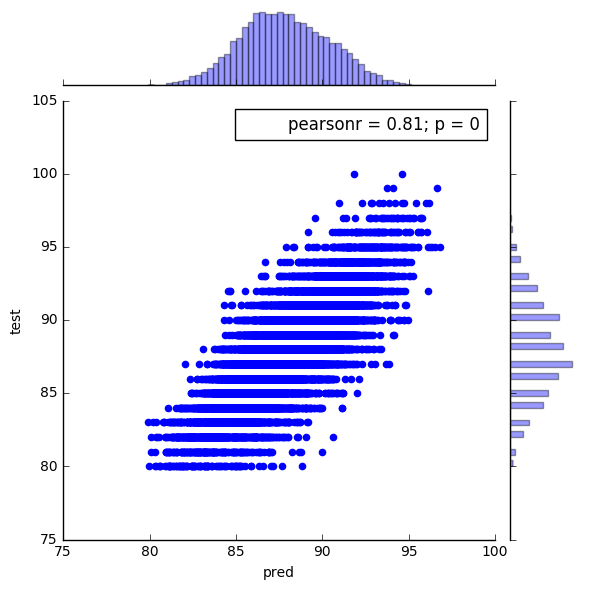

In [137]:
figure = "validation.png"
sns.jointplot(x="pred", y="test", data= test_df)
plt.savefig(figure)

#### The plot above shows that our largest MSE occurs for higher quality wines, where there isn't much training data. This will get better with more training data. It could also be that we have too many categorical variable labels -- which may introduce a lot of variance into the model causing it to overfit. 

## We run through the same pre-processing pipeline for the test dataset to obtain our features

In [81]:
test_df = pd.read_csv("wines_prediction.csv")

In [110]:
test_df_duplicates_dropped = test_df.drop_duplicates(subset = 'description')
test_df_cleaned = test_df_duplicates_dropped.dropna(subset=['price','country', 'variety'])
test_df_fully_cleaned = test_df_cleaned.drop(['region_2'], axis = 1)
test_df_fully_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25127 entries, 0 to 30185
Data columns (total 8 columns):
country        25127 non-null object
description    25127 non-null object
designation    17390 non-null object
price          25127 non-null float64
province       25127 non-null object
region_1       21000 non-null object
variety        25127 non-null object
winery         25127 non-null object
dtypes: float64(1), object(7)
memory usage: 1.7+ MB


In [144]:
test_df_fully_cleaned['region_1']=test_df_fully_cleaned['region_1'].fillna(test_df_fully_cleaned['province'])


In [145]:
create_new_column(test_df_fully_cleaned, 'country', 8)
create_new_column(test_df_fully_cleaned, 'province', 30)
create_new_column(test_df_fully_cleaned, 'region_1', 30)
create_new_column(test_df_fully_cleaned, 'variety', 10, binarize = True)

In [146]:
text_length = []
for items in range(len(test_df_fully_cleaned['description'])):
    text_length.append(len(test_df_fully_cleaned['description'].iloc[items].split()))
test_df_fully_cleaned['descr_length'] = text_length

In [148]:
tokenized_test_set = [" ".join([word for word in simple_preprocess(test_df_fully_cleaned['description'].iloc[item]) if word not in stop_words])
                  for item in range(len(test_df_fully_cleaned['description']))]
test_text_vectors = tfidf.fit_transform(tokenized_test_set)

In [170]:
training_data_labels = ['price', 'country_labels','province_labels', 'region_1_labels'
                        , 'variety_labels', 'descr_length']
                        
X_test = pd.concat([test_df_fully_cleaned['{}'.format(x)] for x in training_data_labels], axis = 1)
full_X_test = np.concatenate((X_test, test_text_vectors.todense()), axis = 1).astype(np.float32)
full_scaled_X_test = scaler.fit_transform(full_X_test)

#### We choose the model with the learning_Rate = 0.1 which had the lowest MSE. Use the entire training data for the modeling

In [174]:
grd =GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
                                learning_rate = 0.1, loss = 'ls')

Training_X = scaler.fit_transform(full_X)

#grd.fit(Training_X, y_train)
#pred_test= grd.predict(X_test_full_scaled)

In [175]:
grd.fit(Training_X, y)
print("Training_Accuracy =", mean_squared_error(y, grd.predict(Training_X)))

Training_Accuracy = 3.05463166114


In [176]:
test_pred = grd.predict(full_scaled_X_test)
test_df_fully_cleaned['pred_score'] = test_pred

In [177]:
test_df_fully_cleaned.head()

,country,description,designation,price,province,region_1,variety,winery,country_labels,province_labels,region_1_labels,variety_labels,descr_length,pred_score
0,France,"Smells leathery and a bit overripe, with scent...",NaN,45.0,Rhône Valley,Châteauneuf-du-Pape,Rhône-style Red Blend,E. Guigal,2,18,30,0,47,90.082655
1,Chile,"Earthy and staunch on the nose, with gentle bu...",Reserve,18.0,Colchagua Valley,Colchagua Valley,Cabernet Sauvignon,El Huique,4,21,19,0,41,87.042799
2,US,Soliloquy was a hit from the very start and th...,Soliloquy,25.0,California,Oakville,Sauvignon Blanc,Flora Springs,0,0,30,0,58,89.632690
3,US,Drinks tighter and steelier than PR Chards of ...,Private Reserve,35.0,California,Napa Valley,Chardonnay,Beringer,0,0,0,0,55,88.871627
4,US,"Lush enough to drink now, with decanting, but ...",Quail Hill Vineyard,40.0,California,Russian River Valley,Chardonnay,Lynmar,0,0,3,0,56,90.152348


### Find the highest predicted score

In [181]:
max_score = test_df_fully_cleaned['pred_score'].max()

In [189]:
test_df_fully_cleaned.loc[test_df_fully_cleaned['pred_score'] == max_score]

,country,description,designation,price,province,region_1,variety,winery,country_labels,province_labels,region_1_labels,variety_labels,descr_length,pred_score
24628,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,1300.0,Bordeaux,Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,2,9,30,0,49,97.346792


### This wine is pretty pricey too but let's find out if there's a more expensive wine

In [192]:
df = test_df_fully_cleaned.sort_values(['price','pred_score'], ascending=[False,False])

In [197]:
df.head()

,country,description,designation,price,province,region_1,variety,winery,country_labels,province_labels,region_1_labels,variety_labels,descr_length,pred_score
14219,US,The nose on this single-vineyard wine from a s...,Roger Rose Vineyard,2013.0,California,Arroyo Seco,Chardonnay,Blair,0,0,30,0,43,93.373459
9719,France,"A massive wine for Margaux, packed with tannin...",NaN,1900.0,Bordeaux,Margaux,Bordeaux-style Red Blend,Château Margaux,2,9,30,0,44,97.270026
15897,France,A wine that has created its own universe. It h...,Clos du Mesnil,1400.0,Champagne,Champagne,Chardonnay,Krug,2,23,23,0,58,97.005606
24628,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,1300.0,Bordeaux,Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,2,9,30,0,49,97.346792
17389,Portugal,"This was a great vintage Port year, and this w...",Colheita White,980.0,Port,Port,Port,Kopke,7,30,30,0,62,95.731202


### After sorting the dataframe, we find that the most expensive wine which is also over 95 is below. 

In [196]:
df.head().iloc[2]

country                                                       France
description        A wine that has created its own universe. It h...
designation                                           Clos du Mesnil
price                                                           1400
province                                                   Champagne
region_1                                                   Champagne
variety                                                   Chardonnay
winery                                                          Krug
country_labels                                                     2
province_labels                                                   23
region_1_labels                                                   23
variety_labels                                                     0
descr_length                                                      58
pred_score                                                   97.0056
Name: 15897, dtype: object